In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
import math
import logging
import matplotlib.pyplot as plt 

In [4]:
D = 30
K = 8

In [5]:
keypoint_dir = "/content/gdrive/MyDrive/keypoint"
# list of keypoints file paths
keypoint_files = sorted(
    [
        os.path.join(keypoint_dir, fname)
        for fname in os.listdir(keypoint_dir)
        if fname.endswith(".npy")
    ]
)

In [6]:
fps = 25.00

In [7]:
# sequence class to load and vectorize batches of data
class Keypoints(keras.utils.Sequence):# iterate images
    def __init__(self, frame_batch, keypoint_files):
        self.frame_batch = frame_batch
        self.files = keypoint_files
        self.keypoints = []
        for f_path in self.files:
            raw_kp = np.load(f_path) 
            # number of batches this keypoint file will be split to 
            n_frame_batches = len(raw_kp) // frame_batch
            for i in range(n_frame_batches):
                # divided the long keypoints sequence to batch_size frames
                kp = raw_kp[i*frame_batch:(i+1)*frame_batch,0:14,0:2]
                self.keypoints.append(kp) 
    
    def __len__(self):
        return len(self.keypoints)
    
    def encode(self, batch):
        frame_batch = self.frame_batch
        features = 9
        joints = 14
        # motion encoder
        A = np.zeros((frame_batch, joints, features))
        
        for j in range(0,joints): # for each joint
            for i in range(1,frame_batch):
                # displacement 
      
                A[i][j][0],  A[i][j][1]= batch[i][j] - batch[i-1][j]  
                A[i][j][2] = math.sqrt(A[i][j][0]**2 + A[i][j][1]**2)

                # speed
                A[i][j][3],  A[i][j][4] = (batch[i][j] - batch[i-1][j])*fps 
                A[i][j][5] = A[i][j][2] * fps

                # distance from joint j to spine_base
                spine_base = (batch[i][8]+batch[i][11])/2
                A[i][j][6], A[i][j][7] = batch[i][j] - spine_base
                A[i][j][8] = math.sqrt(A[i][j][6]**2 + A[i][j][7]**2)

        return A
    
    def __getitem__(self, index):
        # encoded = []
        # for kp in self.keypoints[index*frame_batch : (index+1)*frame_batch]:
        #     encoded.append(self.encode(kp)) 
        # encoded = np.array(encoded)
        # print(f"Generated batch data shape: {encoded.shape}")
        return self.encode(self.keypoints[index])

In [14]:
# batch_size = 32
frame_batch = 128
# Instantiate data Sequences for each split
data_generator = Keypoints(frame_batch, keypoint_files[1:2])

In [15]:
data_generator[1].shape

(128, 14, 9)

In [51]:
class DotLayer(tf.keras.layers.Layer):
 
    def __init__(self, units=8):
        super(DotLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        # initialize the prototype
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True,
                               name='dot_layer')
        print("initialize the prototype")
 
    def call(self,inputs):
        return tf.matmul(inputs, self.w)

    def get_config(self):
        return {"units": self.units}

In [52]:
class MyModel(tf.keras.Model):
    # D: the dimension of the embedding features 
    # K: the number of cluster 
    # KL_weight: balance weight of the similarity term and the temporal order-preserving term
    # SK_inter: the number of Sinkhorn-Knopp iteration
    # alpha: weight of temporal coherence loss
    def __init__(self, frame_batch, D=30, K=8, KL_weight=0.1, SK_inter=5, alpha=1.0, T=10.0):
        super(MyModel, self).__init__()
        self.D = D
        self.K = K
        self.T = T
        self.klw = KL_weight
        self.nit = SK_inter

        self.frame_batch = frame_batch
        self.alpha = alpha
        # self.model = self.build_model()

        # 2-layer MLP   
        self.dense1 = tf.keras.layers.Dense(units=2*D, activation='sigmoid')
        self.dense2 = tf.keras.layers.Dense(units=D, activation='sigmoid')
        self.dot1 = DotLayer()
        self.softmax1 = tf.keras.layers.Softmax()


    def call(self, inputs):
      features = 9
      joints = 14
      D = self.D
      T = self.T
      frame_batch = self.frame_batch 
      x = inputs
      x = tf.reshape(x, shape=(-1, joints*features))

      x = self.dense1(x)
      x = self.dense2(x)

      self.Z = x

      x = self.dot1(x)
      outputs = self.softmax1(x/T)
      
      return outputs
    
    def compile(self):
        super(MyModel, self).compile()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-4)
        
    # build the encoder network
    # def build_model(self):
    #     features = 9
    #     joints = 14
    #     D = self.D
    #     batch_size = self.batch_size
    #     frame_batch = self.frame_batch 
    #     # inputs = keras.Input(shape=(joints, features))
    #     inputs = keras.Input(shape=(frame_batch, joints, features))
    #     x = inputs
    #     # x = tf.keras.layers.Flatten()(x)
    #     x = tf.reshape(x, shape=(-1, frame_batch, joints*features))
        
    #     # 2-layer MLP    
    #     x = tf.keras.layers.Dense(units=2*D, activation='sigmoid')(x)
    #     x = tf.keras.layers.Dense(units=D, activation='sigmoid')(x)
        
    #     # save the embedding features
    #     self.Z = x

    #     linear_layer = DotLayer()
    #     x = linear_layer(x)
    #     # P_ij 
    #     outputs = tf.keras.layers.Softmax()(x)
        
    #     return keras.Model(inputs, outputs)
        
    
    def get_prior(self, x):
        frame_batch = self.frame_batch
        var = tf.math.reduce_variance(x)
        std = tf.math.reduce_std(x)

        T = []
        for i in range(frame_batch):
          T_i = []
          for j in range(K):
            d_ij = abs(i/frame_batch-j/K)/tf.math.sqrt(1/(frame_batch**2)+1/(K**2))
            # Gaussian distribution 
            T_i.append(tf.math.exp(-d_ij**2/(2*var))/std*math.sqrt(2*math.pi))
          T.append(T_i)
        T = tf.stack(T)
        return T
        
    def temporal_ot(self, x):
        Z = self.Z
        # C: learnable prototypes of the K clusters
        C = self.trainable_variables[-1]
        tf.print(tf.math.reduce_max(C))
        T = self.get_prior(x)

        
        frame_batch = self.frame_batch
        k_cluster = self.K
        # balance weight of the similarity term and the temporal order-preserving term
        klw = self.klw
        
        # Sinkhorn-Knopp Algorithm
        v = np.ones((k_cluster,1))
        u = np.ones((frame_batch,1))

        a = u / frame_batch
        b = v / k_cluster 
        K = tf.math.exp((tf.matmul(Z,C) + klw*tf.math.log(T))/klw) 
        # nit the number of Sinkhorn-Knopp iteration
        for i in range(1,self.nit):
        #v = b / np.dot(K.T, u), u = a / np.dot(K, v)
          v = b / tf.matmul(tf.transpose(K), u)
          u = a / tf.matmul(K, v)

        v = tf.squeeze(v)
        u = tf.squeeze(u)
        
        Q_TOT=tf.matmul(tf.linalg.diag(u),tf.matmul(K, tf.linalg.diag(v)))
        tf.print(tf.math.reduce_max(Q_TOT))
        return tf.stack(Q_TOT)
        
    def loss_func(self, P, Q):

        frame_batch = self.frame_batch
        # Cross-Entropy Loss
        l_ce = -tf.math.reduce_sum(tf.multiply(Q,tf.math.log(P)))/frame_batch
        tf.print(tf.math.reduce_sum(tf.multiply(Q,tf.math.log(P))))
        # Temporal Coherence Loss - N pair loss
        Z = self.Z
        
        N = 8
        l = int(frame_batch/N)

        Z_i = []
        Z_positive = []
        window_size = 4
        # sample z_i
        for i in range(N):
          index = i*l + np.random.randint(0,l-1,1)
          z_i = tf.gather(Z, index, axis=0)
          Z_i.append(z_i)
          
          # calculate window range
          min_index = max(0, index - window_size)
          max_index = min(frame_batch - 1, index + window_size)
          # sample z_postive inside the window
          idx_pos = np.random.randint(min_index, max_index,1)
          z_ip = tf.squeeze(tf.gather(Z, idx_pos, axis=0))
          Z_positive.append(z_ip)

        Z_i = tf.stack(Z_i)
        Z_positive = tf.stack(Z_positive)


        l_tc = 0
        for i in range(N):  
          denominator = tf.reduce_sum(tf.exp(tf.matmul(Z_i[i],tf.transpose(Z_positive))),axis=1, keepdims=True)
          l_tc += tf.squeeze(tf.math.log(tf.exp(tf.matmul(Z_i[i],tf.reshape(Z_positive[i],shape=(self.D,1)))/denominator)))
        l_tc = - l_tc/N
        tf.print("LCE:", l_ce,"LTC:",l_tc)
        return 0.1*l_ce + self.alpha*l_tc
        
        
    def train_step(self, data):
        x = data
        
        with tf.GradientTape() as tape:
            P = self(x, training=True)
            Q = self.temporal_ot(x)
            loss = self.loss_func(P,Q)
        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # update weights using the optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {'loss': loss}
    def get_config(self):

        return {"frame_batch": self.frame_batch,"D": self.D, "K": self.K,"KL_weight": self.klw,"SK_inter": self.nit,"alpha": self.alpha,"T": self.T}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [53]:
model = MyModel(128)
model.compile()
model.build(input_shape=(128, 14, 9))
model.summary()

initialize the prototype
Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  7620      
                                                                 
 dense_9 (Dense)             multiple                  1830      
                                                                 
 dot_layer_4 (DotLayer)      multiple                  240       
                                                                 
 softmax_4 (Softmax)         multiple                  0         
                                                                 
Total params: 9,690
Trainable params: 9,690
Non-trainable params: 0
_________________________________________________________________


In [56]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/logs/motion_tracking.h5", save_best_only=True)]
history = model.fit(data_generator, epochs=5, callbacks=callbacks)

Epoch 1/5
0.156275511
0.00237630308
-2.07865405
LCE: 0.0162394848 LTC: -0.0354671963
 1/34 [..............................] - ETA: 3s - loss: -0.03380.156677559
0.00266928226
-2.07892585
LCE: 0.0162416082 LTC: -0.0338396505
0.15706861
0.00225992873
-2.07906866
LCE: 0.0162427239 LTC: -0.0392670333
 3/34 [=>............................] - ETA: 1s - loss: -0.03460.157445
0.00218033418
-2.07908297
LCE: 0.0162428357 LTC: -0.0418485217
0.157801747
0.00195391942
-2.07856035
LCE: 0.0162387528 LTC: -0.0323261321
 5/34 [===>..........................] - ETA: 1s - loss: -0.03490.158174008
0.00253408402
-2.07889986
LCE: 0.0162414052 LTC: -0.0403650701
0.158554882
0.00240458082
-2.07892561
LCE: 0.0162416063 LTC: -0.044067096
 7/34 [=====>........................] - ETA: 1s - loss: -0.03650.158919036
0.00205158815
-2.07867908
LCE: 0.0162396803 LTC: -0.0440919213
0.159274489
0.00183787197
-2.07911277
LCE: 0.0162430685 LTC: -0.0427997336
 9/34 [======>.......................] - ETA: 1s - loss: -0.0377

34/34 [==============================] - 2s 46ms/step - loss: -0.0416
Epoch 2/5
0.165767729
0.00204282254
-2.07868171
LCE: 0.0162397 LTC: -0.0456505343
 1/34 [..............................] - ETA: 3s - loss: -0.04400.166066781
0.00274512917
-2.07874846
LCE: 0.0162402224 LTC: -0.0448660478
0.166393951
0.002062466
-2.07886386
LCE: 0.0162411239 LTC: -0.0452760123
 3/34 [=>............................] - ETA: 1s - loss: -0.04360.166733071
0.00175693631
-2.07922435
LCE: 0.0162439402 LTC: -0.0457549617
 4/34 [==>...........................] - ETA: 1s - loss: -0.04380.167052791
0.00236434862
-2.07907414
LCE: 0.0162427668 LTC: -0.0467350483
0.167367026
0.00203391165
-2.07874346
LCE: 0.0162401833 LTC: -0.0461990647
 6/34 [====>.........................] - ETA: 1s - loss: -0.04410.167707026
0.00257635955
-2.07891774
LCE: 0.0162415449 LTC: -0.0460336171
 7/34 [=====>........................] - ETA: 1s - loss: -0.04420.168052405
0.00200378522
-2.07910585
LCE: 0.0162430145 LTC: -0.0450046621
0.168

34/34 [==============================] - 2s 46ms/step - loss: -0.0442
Epoch 3/5
0.180076748
0.00243546255
-2.07901049
LCE: 0.0162422694 LTC: -0.0464869142
 1/34 [..............................] - ETA: 3s - loss: -0.04490.180564761
0.00217448547
-2.07862139
LCE: 0.0162392296 LTC: -0.0453473218
0.181076229
0.00246367604
-2.07910347
LCE: 0.0162429959 LTC: -0.0459521413
 3/34 [=>............................] - ETA: 1s - loss: -0.04430.181562319
0.00308042113
-2.07857847
LCE: 0.0162388943 LTC: -0.0454942
0.182069167
0.00258590933
-2.07853079
LCE: 0.0162385218 LTC: -0.046577476
 5/34 [===>..........................] - ETA: 1s - loss: -0.04430.182599366
0.00234673359
-2.07875514
LCE: 0.0162402745 LTC: -0.0460580736
0.183130056
0.00219658483
-2.07848215
LCE: 0.0162381418 LTC: -0.0470654555
 7/34 [=====>........................] - ETA: 1s - loss: -0.04450.183685228
0.00259697251
-2.07871675
LCE: 0.0162399746 LTC: -0.0468468927
0.184243783
0.00248174183
-2.07860518
LCE: 0.0162391029 LTC: -0.0470

34/34 [==============================] - 2s 44ms/step - loss: -0.0446
Epoch 4/5
0.199195608
0.00293753203
-2.0784893
LCE: 0.0162381977 LTC: -0.0470863953
 1/34 [..............................] - ETA: 3s - loss: -0.04550.19984968
0.0030111447
-2.07797241
LCE: 0.0162341595 LTC: -0.0445762612
0.200563252
0.00326854
-2.07819343
LCE: 0.0162358861 LTC: -0.0471753553
 3/34 [=>............................] - ETA: 1s - loss: -0.04470.201280072
0.00255066901
-2.07845259
LCE: 0.0162379108 LTC: -0.046358645
0.201978788
0.00277759507
-2.07826757
LCE: 0.0162364654 LTC: -0.0466054976
 5/34 [===>..........................] - ETA: 1s - loss: -0.04470.202689171
0.00260561891
-2.0777545
LCE: 0.016232457 LTC: -0.0455728
0.203456402
0.00310795475
-2.07832742
LCE: 0.0162369329 LTC: -0.045465976
 7/34 [=====>........................] - ETA: 1s - loss: -0.04450.204223916
0.00322548766
-2.07818
LCE: 0.0162357818 LTC: -0.0457950681
0.204974085
0.00311621092
-2.07827473
LCE: 0.0162365213 LTC: -0.0468740389
 9/34

34/34 [==============================] - 2s 43ms/step - loss: -0.0449
Epoch 5/5
0.222814858
0.00332871079
-2.07769966
LCE: 0.0162320286 LTC: -0.0466939323
 1/34 [..............................] - ETA: 3s - loss: -0.04510.223447263
0.00393682346
-2.07754564
LCE: 0.0162308253 LTC: -0.0456594378
0.224097967
0.00442752242
-2.0784452
LCE: 0.0162378531 LTC: -0.0463657603
 3/34 [=>............................] - ETA: 1s - loss: -0.04460.224709108
0.00470053405
-2.07695222
LCE: 0.0162261892 LTC: -0.0481670164
0.225338876
0.00360199437
-2.0774796
LCE: 0.0162303094 LTC: -0.0468126312
 5/34 [===>..........................] - ETA: 1s - loss: -0.04510.226019308
0.00458143279
-2.07757473
LCE: 0.0162310526 LTC: -0.0472580232
0.226685628
0.00484180078
-2.07845211
LCE: 0.0162379071 LTC: -0.0459601469
 7/34 [=====>........................] - ETA: 1s - loss: -0.04510.227300361
0.00459862873
-2.07794642
LCE: 0.0162339564 LTC: -0.0474546514
0.227897838
0.00343033671
-2.07764459
LCE: 0.0162315983 LTC: -0.04

34/34 [==============================] - 2s 44ms/step - loss: -0.0451


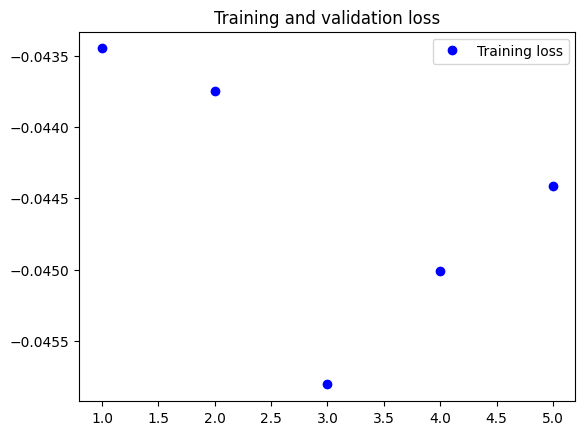

In [58]:
loss = history.history['loss']

epochs = range(1,6)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [59]:
# save model
model.save('/content/gdrive/MyDrive/Colab Notebooks/logs/my_model')

In [60]:
P = model.predict(data_generator[0])

4/4 [==============================] - 0s 2ms/step


In [61]:
P = np.argmax(P, axis=1)

In [62]:
np.mean(P)

4.578125

In [63]:
P

array([0, 0, 7, 2, 2, 4, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 2, 2,
       4, 7, 2, 7, 7, 7, 7, 4, 7, 7, 7, 2, 7, 2, 7, 7, 4, 4, 7, 7, 7, 2,
       7, 7, 7, 7, 7, 4, 2, 2, 7, 7, 7, 2, 4, 7, 2, 7, 2, 7, 7, 7, 7, 7,
       7, 2, 7, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 2, 4, 2, 7, 4, 4, 7, 0, 4,
       4, 0, 4, 0, 4, 4, 0, 2, 4, 4, 0, 4, 4, 7, 4, 4, 4, 4, 4, 4, 7, 4,
       2, 7, 2, 2, 6, 7, 0, 2, 2, 0, 4, 0, 4, 2, 2, 4, 0, 0])